In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd

import math

from util import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
class Node:
    def __init__(self, parent, state, n_children, value, depth=0):
        self.state = state
        self.parent = parent
        self.visits = 0
        self.depth = depth
        self.children = [None] * n_children
        self.is_terminal = terminal(self.state)
        self.value = value
        self.subtree_value = torch.zeros(1).to(device)

    def __str__(self):
        return ("State: " + str(self.state) + "; Value: " + str(self.value)
                + "; Subtree Value: " + str(self.subtree_value) + "; Visits:", str(self.visits))

    def is_leaf(self):
        for i in self.state:
            if i is not None:
                return False
        return True
class MCTS:
    def __init__(self, actions, C, weight, value_fn):
        self.actions = actions
        self.k_C = C
        self.k_weight = weight
        self.value_fn = value_fn
        self.max_depth = 0
        self.terminal = None    # None if no terminal state found; terminal Node if found
        self.root = None

    def pick_child(self, node):
        # UCT
        t = []
        for i in node.children:
            if i is None:
                continue
            t.append(UCT_fn(i, self.k_C))

        t = torch.tensor(t)

        rvs = torch.squeeze(torch.argwhere(t == torch.max(t)), axis=1)
        if len(rvs) == 0:
            return random.randint(0, len(node.children)-1)
        return int(random.choice(rvs))

    def default_search(self, node):
        """
        If node is fully explored (neither child is None), return True
        Otherwise, initialize value of a random unexplored next state

        :param node: node to search from
        :return: if fully explored, True. Else, value of the random unexplored next state
        """
        possible = []
        for i in range(len(node.children)):
            if node.children[i] is None:
                possible.append(i)
        if len(possible) == 0:
            return True

        i = random.choice(possible)
        # if unexplored or non-terminal, get value
        state = self.actions[i](node.state.flatten()).float().to(device)
        state = state.reshape(node.state.shape)
        # child_val = self.value_fn(state) - node.depth - 1  # give penalty -1 for each additional step taken
        child_val = self.value_fn(state)
        child_val = child_val.flatten()[0]
        node.children[i] = Node(node, state, len(self.actions), value=child_val, depth=node.depth+1)

        # if new Node is terminal, take it as the tree's terminal if it takes less time to reach than current terminal
        # if node.children[i].is_terminal:
        #     # if terminal, add reward of ||start_vec||_2^2
        #     node.children[i].value += torch.linalg.vector_norm(torch.square(self.root.state)).item()
        #     if self.terminal is None or node.children[i].depth < self.terminal.depth:
        #         self.terminal = node.children[i]

        if node.children[i].depth > self.max_depth:
            self.max_depth = node.children[i].depth
        return node.children[i]

    def tree_policy(self, node, computations):
        while node.is_terminal is False:
            explored = self.default_search(node)
            if explored is not True:
                return explored, computations + 1
            node = node.children[self.pick_child(node)]
            # node = random.choice(node.children)
        return node, computations + 1

    def mean_prop(self, node):
        """
        Backprop up from a leaf, where subtree_value is the average of a node's rewards and its subtree's rewards

        :param node: of subtree
        """
        node.subtree_value = torch.zeros(1).to(device)
        node.subtree_value += node.value
        valid_children = 0
        if not node.is_leaf():
            for i in node.children:
                if i is None:
                    continue
                node.subtree_value += self.k_weight * i.subtree_value
                valid_children += 1
        node.subtree_value /= valid_children + 1
        node.visits += 1
        if node.parent is None:
            return
        self.mean_prop(node.parent)

    def run(self, root, comp_limit=10):
        """
        Shoutout "A Survey of MCTS Methods"
        :param root: the current state
        :param comp_limit: max number of possible future scenarios to compute (carries over)
        :return: index corresponding to best action
        """
        self.root = root
        if self.root.is_terminal:
            return True
        comps = 0
        while comps < comp_limit:
            node, comps = self.tree_policy(self.root, comps)
            self.mean_prop(node)

        rv = self.pick_child(self.root)

        if False:
            print("root state:", root.state)
            print("child states: ",end="")
            for child in root.children:
                print(child.state, end=",")
            print()
        return rv
    
    def generate(self, init_state, actions):
        self.root = Node(None, init_state, n_children=len(self.actions), value=self.value_fn(init_state), depth=0)
        curr = self.root
        r_nodes = []
        for i in actions:
            newstate = self.actions[i](curr.state)
            n = Node(parent=curr,
                     state=newstate,
                     n_children=len(self.actions),
                     value=self.value_fn(newstate),
                     depth=curr.depth + 1)
            curr.children[i] = n
            curr = n            
            r_nodes.append(n)
        return r_nodes

        

In [3]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.v_loss_fn = torch.nn.MSELoss()
        self.p_loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, v_out, v_target, p_out, p_target):
        """
        Loss function designed to reward successful game completion while taking the least amount of steps possible
        Adapted from:
            - "Mastering the game of Go without human knowledge" (Silver et al)
            - "Discovering faster matrix multiplication algorithms with reinforcement learning" (Fawzi et al)

        :param v_out: the value outputed for the state by NN
        :param p_out: the policy outputed for the state by NN
        :param v_target: target value output
        :return: total loss
        """
        loss = self.v_loss_fn(v_out, v_target)
        loss += self.p_loss_fn(p_out, p_target).sum()
        return loss


class ValueNN(nn.Module):
    def __init__(self, state_size):
        super(ValueNN, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        self.value_activation = nn.ReLU()
    def forward(self, x):
#        x = self.flatten(x)
#        x = self.stack(x).flatten()
#        value = x[0:1].reshape((1,1))
#        return value
        return self.stack(x)


class PolicyNN(nn.Module):
    def __init__(self, state_size, n_actions):
        super(PolicyNN, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions),
        )
        self.policy_activation = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.policy_activation(self.stack(x))#.flatten())
        policy = torch.clamp(x,min=1e-8,max=1-(1e-8))
        return policy

In [4]:
# Memory for better batching

class Memory:
    def __init__(self, width) -> None:
        self.mem_ = torch.empty((0,width)).to(device)
        self.len_ = 0
    def record(self, obs):
        self.mem_ = torch.cat((self.mem_, obs), dim=0)
        self.len_ += 1
    def recall(self, n_samples):
        if self.len_ == 0:
            return None
        des_len = min(n_samples, self.len_)
        indices = torch.ones(self.mem_.shape[0]).multinomial(des_len, replacement=False)
        return self.mem_[indices]
    def size(self):
        return self.len_

In [5]:
import math

k_C = 1 / math.sqrt(2)

def get_train_data(fname):
    x = np.loadtxt(fname, delimiter=",")
    return torch.tensor([x[:,2], x[:,2:]], dtype=torch.float)

def get_nonterm_rwd(mcts):
    return -mcts.max_depth

def get_terminal_rwd(terminal_depth, start):
    return -terminal_depth + torch.linalg.norm(start)

def train_sv(epochs, actions, policy_fn, value_fn, optimizers, fname, batch_size=10):
    k_mem_width = 4    # statex,statey,action,subtree_value
    memory = Memory(k_mem_width)
    loss_fn = Loss()
    # load data into memory
    with open(fname, 'r') as f:
        for line in f.readlines():
            entry = torch.tensor(list(map(int, line.split(','))))
            tree = MCTS(actions, C=k_C, weight=1, value_fn=value_fn)
            g_nodes = tree.generate(entry[0:2].unsqueeze(0).float(), entry[2:])
            for i in range(len(entry) - 2): # go by actions (so we disregard the terminal node)
                memory.record(torch.cat((g_nodes[i].state.reshape(1,2), 
                                         entry[2+i].reshape((1,1)), 
                                         g_nodes[i].subtree_value.reshape(1,1)), dim=1))
    # train off memory
    for t in range(epochs):
        for o in optimizers:
            o.zero_grad()
        batch = memory.recall(batch_size)
        v_out = value_fn(batch[:,:2])
        p_out = policy_fn(batch[:,:2])

        # one-hot encode actions; e.g. convert 3 -> (0,0,0,1)
        action_indices = batch[:,2:-1].to(torch.int64)
        p_target = oh_encode(action_indices, len(actions))
        # p_target = torch.zeros(action_indices.shape[0],len(actions))
        # p_target.scatter_(1, action_indices,1)

        v_target = batch[:,-1]

        loss = loss_fn(v_out.view(v_target.shape), v_target, p_out.view(p_target.shape), p_target)
        loss.backward()

        for o in optimizers:
            o.step()
    
        if (t+1) % 10 == 0:
            print("Epoch:", t+1,"\t\tLoss:",loss.item())


def train_play(epochs, actions, policy_fn, value_fn, optimizers, rand_start_state_fn, comp_limit, batch_size=16):
    history = Memory(2+len(actions))    # [stateX,stateY,pr1,pr2,...pr(len(actions))] (probs are sampled probs)
    loss_fn = Loss()
    for t in range(epochs):
        for o in optimizers:
            o.zero_grad()
        # Repeat the following:
        # 1) run the NN on some random initial state
        # 2) update the NN based off performance in that game
        mcts = MCTS(actions, C=k_C, weight=1, value_fn=value_fn)
        start = rand_start_state_fn().to(device)

        value = mcts.value_fn(start).flatten().to(device)
        policy = policy_fn(start).flatten().to(device)

        start_node = Node(None, start, len(actions), value, 0)

        # play out a game
        mcts.run(start_node, comp_limit=comp_limit)


        # get attributes of game just played
        v_out = start_node.subtree_value.to(device)
        v_target = get_nonterm_rwd(mcts)
        if mcts.terminal is not None:
            v_target = get_terminal_rwd(mcts.terminal.depth, start)
        v_target = torch.tensor(v_target,dtype=v_out.dtype).to(device)


        visits = []
        for i in start_node.children:
            if i is None:
                visits.append(0)
            else:
                visits.append(i.visits)
        visits = torch.tensor(visits, dtype=torch.float).to(device)
        p_sampled = visits / torch.sum(visits)

        curr_batch_entry = torch.cat((start,p_sampled.flatten().unsqueeze(0)),dim=1)
        hist = history.recall(batch_size)
        batch = curr_batch_entry
        if hist is not None:
            batch = torch.cat((hist, batch),dim=0)
        batch_states = batch[:,:2]
        batch_psampled = batch[:,2:]

        # v_loss = v_loss_fn(v_out, torch.tensor(v_target,dtype=v_out.dtype))
        # p_loss = p_loss_fn(policy_fn(batch_states), batch_psampled)
        loss = loss_fn(v_out, v_target,
                       policy_fn(batch_states).reshape(batch_psampled.shape), batch_psampled)
        loss.backward()
        # v_loss.backward()
        # p_loss.backward()

        for o in optimizers:
            o.step()

        history.record(curr_batch_entry)

        if (t+1) % 10 == 0:
            print("Epoch:", t+1,"\t\tLoss:",loss.item())
            # if torch.isnan(p_loss):
            #     print("value",v_out)

In [5]:
k_state_upper_lim = 30 # arbitrary
k_comp_limit = int(k_state_upper_lim ** (3/2))
value_fn_2 = ValueNN(2).to(device)
policy_fn_2 = PolicyNN(2,len(k_2actions)).to(device)
value_optim = optim.Adam(value_fn_2.parameters(), lr=0.00005)
policy_optim = optim.Adam(policy_fn_2.parameters(), lr=0.00005)

def gen_start_state_2a():
    limit = k_state_upper_lim
    return torch.round(torch.rand((1, 2)) * limit + 1).float()



In [39]:
# synthetic data
train_play(epochs=500, actions=k_2actions, policy_fn=policy_fn_2, value_fn=value_fn_2, optimizers=[value_optim, policy_optim], rand_start_state_fn=gen_start_state_2a, comp_limit=k_comp_limit)

Epoch: 10 		Loss: 83.53762817382812
Epoch: 20 		Loss: 58.634559631347656
Epoch: 30 		Loss: 73.7419662475586
Epoch: 40 		Loss: 82.62555694580078
Epoch: 50 		Loss: 30.83740997314453
Epoch: 60 		Loss: 82.79553985595703
Epoch: 70 		Loss: 76.37242889404297
Epoch: 80 		Loss: 78.2113265991211
Epoch: 90 		Loss: 85.37519836425781
Epoch: 100 		Loss: 61.07470703125
Epoch: 110 		Loss: 86.727294921875
Epoch: 120 		Loss: 43.60294723510742
Epoch: 130 		Loss: 62.046077728271484
Epoch: 140 		Loss: 128.45828247070312
Epoch: 150 		Loss: 121.83206939697266
Epoch: 160 		Loss: 35.638004302978516
Epoch: 170 		Loss: 49.17754364013672
Epoch: 180 		Loss: 1.2331846952438354
Epoch: 190 		Loss: 47.58385467529297
Epoch: 200 		Loss: 27.664323806762695
Epoch: 210 		Loss: 54.58678436279297
Epoch: 220 		Loss: 22.225751876831055
Epoch: 230 		Loss: 89.01606750488281
Epoch: 240 		Loss: 14.566844940185547
Epoch: 250 		Loss: 43.948638916015625
Epoch: 260 		Loss: 2.603121280670166
Epoch: 270 		Loss: 5.078288555145264
Epoch: 

In [34]:
save = False
if save:
    torch.save(value_fn_2.state_dict(), "trained_weights/deep_mcts_2_v_weights.pth")
    torch.save(policy_fn_2.state_dict(), "trained_weights/deep_mcts_2_p_weights.pth")

In [6]:
k_state_upper_lim = 30 # arbitrary
k_comp_limit = int(k_state_upper_lim ** (7/2))
value_fn_4 = ValueNN(2).to(device)
policy_fn_4 = PolicyNN(2,len(k_4actions)).to(device)
value_optim_4 = optim.Adam(value_fn_4.parameters(), lr=0.00005)
policy_optim_4 = optim.Adam(policy_fn_4.parameters(), lr=0.000005)

def gen_start_state_4a():
    limit = k_state_upper_lim
    return torch.round( (torch.rand((1, 2)) - 0.5) * 2 * limit).float()


In [18]:
train_sv(250, k_4actions, policy_fn=policy_fn_4, value_fn=value_fn_4, optimizers=[value_optim_4,policy_optim_4], fname='train_data/train_mcts.csv', batch_size=16)

Epoch: 10 		Loss: 2.1033401489257812
Epoch: 20 		Loss: 1.556889295578003
Epoch: 30 		Loss: 1.3582837581634521
Epoch: 40 		Loss: 1.4088467359542847
Epoch: 50 		Loss: 1.436020016670227
Epoch: 60 		Loss: 1.379128336906433
Epoch: 70 		Loss: 1.4841262102127075
Epoch: 80 		Loss: 1.3614771366119385
Epoch: 90 		Loss: 1.3785827159881592
Epoch: 100 		Loss: 1.3600499629974365
Epoch: 110 		Loss: 1.389901041984558
Epoch: 120 		Loss: 1.383531928062439
Epoch: 130 		Loss: 1.3663393259048462
Epoch: 140 		Loss: 1.3774583339691162
Epoch: 150 		Loss: 1.2760998010635376
Epoch: 160 		Loss: 1.3536250591278076
Epoch: 170 		Loss: 1.3584808111190796
Epoch: 180 		Loss: 1.3749842643737793
Epoch: 190 		Loss: 1.3323438167572021
Epoch: 200 		Loss: 1.3520457744598389
Epoch: 210 		Loss: 1.310624599456787
Epoch: 220 		Loss: 1.3285794258117676
Epoch: 230 		Loss: 1.3432512283325195
Epoch: 240 		Loss: 1.3051739931106567
Epoch: 250 		Loss: 1.3170291185379028


In [8]:
init_policy_fp = "start_weights/deep_mcts_4_p_weights.pth"
init_value_fp = "start_weights/deep_mcts_4_v_weights.pth"
trained_policy_fp = "trained_weights/deep_mcts_4_p_weights_f.pth"
trained_value_fp = "trained_weights/deep_mcts_4_v_weights_f.pth"

In [ ]:

if False:
    torch.save(value_fn_4.state_dict(), init_value_fp)
    torch.save(policy_fn_4.state_dict(), init_policy_fp)

/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_3944/2326664682.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(x[i]).unsqueeze(0)


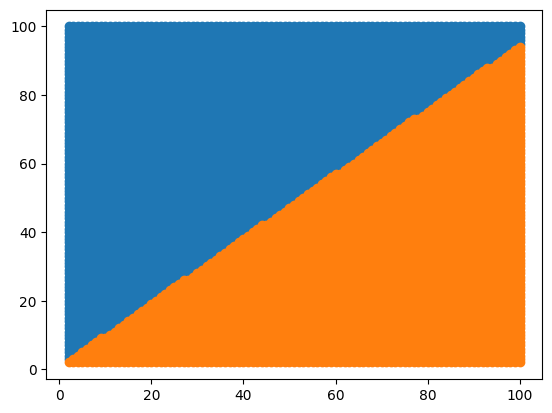

Test Accuracy: 0.967
Guess Distribution: [1086, 914]


In [16]:
train_play(epochs=100, actions=k_4actions, policy_fn=policy_fn_4, value_fn=value_fn_4, optimizers=[value_optim_4, policy_optim_4], rand_start_state_fn=gen_start_state_4a, comp_limit=k_comp_limit)

In [13]:
# Test trained weights


# value_fn_4.load_state_dict(torch.load(trained_value_fp))
# policy_fn_4.load_state_dict(torch.load(trained_policy_fp))


In [10]:
def get_test_data(fname):
    x = torch.tensor(np.loadtxt(fname, delimiter=","), dtype=torch.float)
    return x[:,:-1], x[:,-1]

def plot_db(policy_fn, actions, ranges):
    X = ranges[0]
    Y = ranges[1]
    action_plot = []
    for i in actions:
        action_plot.append([])
    for i in X:
        for j in Y:
            rv = policy_fn(torch.tensor([i,j],dtype=torch.float)).reshape(1,len(actions)).to(device)
            action_plot[torch.argmax(rv)].append((i.cpu(),j.cpu()))
    for i in range(len(action_plot)):
        action = np.array(action_plot[i])
        plt.scatter(action[:,0], action[:,1], color=("C"+str(i)), label=action)
    plt.show()

In [11]:
def test(x, y, policy_fn, actions=k_2actions, dbs=None):
    correct = 0
    guess_dist = [0] * len(actions)
    for i in range(len(x)):
        state = torch.tensor(x[i]).unsqueeze(0).to(device)
        rv = policy_fn(state).flatten()                      # take the move distribution given by NN

        # todo pick one way to select
        # rv = rv.multinomial(num_samples=1, replacement=True)    # sample from the move distribution
        rv = torch.argmax(rv)

        if rv == y[i]:
            correct += 1
        guess_dist[rv] += 1
    # todo fix
    if dbs is not None:
        # graphing decision boundary
        plot_db(policy_fn, actions, ranges=dbs)
    return correct / len(x), guess_dist


def run_test(data_name, actions, policy_fn, cases=100, dbs=None):
    test_X, test_Y = get_test_data(data_name)
    test_X = test_X.to(device)
    test_Y.reshape(-1, 1)
    test_Y = test_Y.to(device)

    acc, guesses = test(x=test_X[:cases], y=test_Y[:cases],
                        policy_fn=policy_fn, actions=actions, dbs=dbs)
    print("Test Accuracy:", acc)
    print("Guess Distribution:", guesses)


/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_8778/3537842439.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(x[i]).unsqueeze(0).to(device)


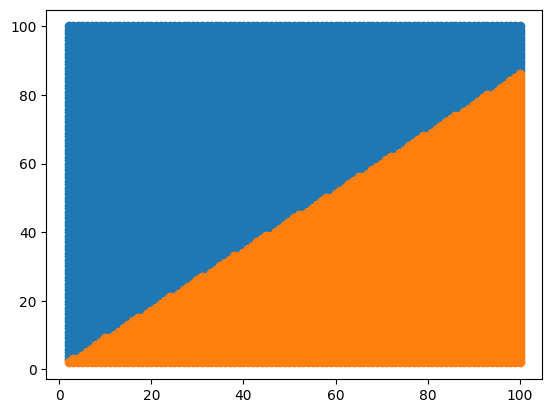

Test Accuracy: 0.9275
Guess Distribution: [1165, 835]


In [12]:
k_cases = 2000
k_dbound_size = 100

dual_file = "test_data/test_simple.csv"

db2 = torch.linspace(2, k_dbound_size, k_dbound_size - 1).to(device)
two_dbs = [db2, db2]

run_test(dual_file, k_2actions, policy_fn=policy_fn_2, cases=k_cases, dbs=two_dbs)
# ~99% accuracy

In [14]:
quad_file = "test_data/four_directions_cleaner_test.csv"     # thanks, donald

k_cases = 1000

k_dbound_size = 200

db4 = torch.linspace(-k_dbound_size/2, k_dbound_size/2, k_dbound_size+1).to(device)
quad_dbs = [db4, db4]
run_test(quad_file, k_4actions, policy_fn=policy_fn_4, cases=k_cases)
            
# run_test(quad_file, k_4actions, policy_fn=lambda a: oh_encode(torch.tensor(determine_action(a.flatten())).view((1,1)),4), cases=k_cases, dbs=quad_dbs)
# # 8% accuracy on Donald test csv

Test Accuracy: 0.261
Guess Distribution: [1000, 0, 0, 0]


/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_8108/450618715.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(x[i]).unsqueeze(0).to(device)
